In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import datasets

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
train_set, test_set = datasets.load_MNIST()

#split validation set
train_set, val_set = datasets.split_validation(train_set, percentage=0.2)

train_x, train_y = train_set
val_x, val_y = val_set

n_samples = len(train_x)
n_val = len(val_x)
print(n_samples)
print(n_val)

Extracting /home/glazari/DataSets/MNIST/train-images-idx3-ubyte.gz
Extracting /home/glazari/DataSets/MNIST/train-labels-idx1-ubyte.gz
Extracting /home/glazari/DataSets/MNIST/t10k-images-idx3-ubyte.gz
Extracting /home/glazari/DataSets/MNIST/t10k-labels-idx1-ubyte.gz
44000
11000


In [3]:
# helper functions
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

sigmoid = tf.nn.sigmoid
elu = tf.nn.elu

def bias(size, zero=False, name='n'):
    if zero:
        return tf.Variable(tf.zeros([size], dtype=tf.float32),name=name)
    else:
        return tf.Variable(tf.random_normal([size], stddev=0.1),name=name)

def conv(tensor, kernel_dims, name='n'):
    ksize, n_in, n_out = kernel_dims
    kernels = tf.Variable(tf.random_normal([ksize, ksize, n_in, n_out],  stddev=0.1), name=name+'.kernel')
    return tf.nn.conv2d(tensor,kernels, strides=[1, 2, 2, 1], padding='SAME') + bias(n_out, name=name+'.bias')

def deconv(tensor, kernel_dims, out_dim, stride=[1,2,2,1], name='n'):
    ksize, n_out, n_in = kernel_dims
    kernels = tf.Variable(tf.random_normal([ksize, ksize, n_out, n_in], stddev=0.1),name=name+'_kernel')
    out_dim = tf.stack(out_dim)
    return tf.nn.conv2d_transpose(tensor,kernels,out_dim,strides=stride,padding='SAME')+\
            bias(n_out,name=name+'.bias')

def dense(tensor, in_size, out_size,name='n'):
    weights = tf.Variable(xavier_init(in_size, out_size),name=name+'.weights')
    return tf.matmul(tensor, weights,name=name) + bias(out_size,name=name+'.bias')
    

def clip(tensor, _max=None, _min=None):
    return tf.clip_by_value(tensor, clip_value_min=_min, clip_value_max=_max)

In [4]:
#model
batch_size = 100
n_input = 28*28
n1 = 500
n2 = 500
n_z = 20

x = tf.placeholder(tf.float32, [None, n_input],name='X')
n_ex = tf.shape(x)[0] #number of examples

#attack layer starts out at zero
attack = tf.Variable(tf.zeros([n_input], dtype=tf.float32),name='Attack')
adv_x = clip(x + attack, _min=0, _max=1)

#encoder
enc_1 = elu(dense(adv_x, n_input, n1, name='enc_1'))
enc_2 = elu(dense(enc_1, n1, n2, name='enc_1'))
z_mean = dense(enc_2, n2, n_z, name='z_mean')
z_log_var = dense(enc_2, n2, n_z, name='z_log_var')

#sample z
eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)
# z = mu + sigma*epsilon
z = z_mean + eps*tf.sqrt(tf.exp(z_log_var))

#decoder
dec_1 = elu(dense(z, n_z, n2),name='dec_1')
dec_2 = elu(dense(dec_1, n2, n1),name='dec_2')
out_mean = sigmoid(dense(dec_2, n1, n_input,name='out_mean'))

In [5]:
sess = tf.InteractiveSession()

In [6]:
#loss
reconstr_loss = -tf.reduce_sum(x * tf.log(1e-8 + out_mean) + (1-x) * tf.log(1e-8 + 1 - out_mean), axis=1,name='rec')
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1,name='latent')
cost = tf.reduce_mean(reconstr_loss + latent_loss,name='cost')


all_vars = sess.graph.get_collection('trainable_variables')
w = [var for var in all_vars if 'Attack' not in var.name]

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost,var_list=w)

#Adversarial part of the model
Target = tf.placeholder(tf.float32, [None, n_z],name='target')
C = tf.placeholder(tf.float32, name='C')
target_cost = tf.reduce_mean(tf.square(Target - z_mean)) + C*tf.nn.l2_loss(attack)

target_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(target_cost,var_list=attack)

init_attack = tf.variables_initializer([attack])

init = tf.global_variables_initializer()

In [7]:
def partial_fit(X):
    """Train model based on mini-batch of input data.

    Return cost of mini-batch.
    """
    opt, c = sess.run((optimizer, cost), 
                              feed_dict={x: X})
    return c

def get_cost(X):
    c = sess.run((cost), feed_dict={x: X})
    return c


def reconstruct(X):
    """ Use VAE to reconstruct given data. """
    return sess.run(out_mean, feed_dict={x: X})


EPOCH: 0001, COST: 149.87664, VAL_COST: 122.51497
EPOCH: 0011, COST: 104.86156, VAL_COST: 105.33374
EPOCH: 0021, COST: 102.19008, VAL_COST: 103.12239
EPOCH: 0031, COST: 100.59557, VAL_COST: 101.75748
EPOCH: 0041, COST: 99.60857, VAL_COST: 100.77328
EPOCH: 0051, COST: 98.94588, VAL_COST: 100.42582
EPOCH: 0061, COST: 98.32927, VAL_COST: 99.81745
EPOCH: 0071, COST: 97.84033, VAL_COST: 99.17080
EPOCH: 0081, COST: 97.47559, VAL_COST: 99.12183
EPOCH: 0091, COST: 97.21846, VAL_COST: 98.93585
EPOCH: 0101, COST: 96.92255, VAL_COST: 98.50700
EPOCH: 0111, COST: 96.69488, VAL_COST: 98.49624
EPOCH: 0121, COST: 96.44548, VAL_COST: 98.82100
EPOCH: 0131, COST: 96.30931, VAL_COST: 98.46324
EPOCH: 0141, COST: 96.13850, VAL_COST: 98.69741
EPOCH: 0150, COST: 96.05773, VAL_COST: 98.40053


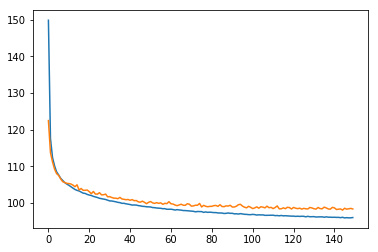

In [8]:
training_epochs = 150
display_step = 10

sess.run(init)
# Training cycle
val_losses = []
losses = []
for epoch in range(training_epochs):
    avg_cost = 0.
    avg_val = 0.
    # Loop over all batches
    for batch_xs, ys in datasets.batches(train_x, train_y, batch_size=batch_size):
        if len(batch_xs) != batch_size:
            continue
        # Fit training using batch data
        c = partial_fit(batch_xs)
        # Compute average loss
        avg_cost += c / n_samples * batch_size
    
    #validation set costs
    for batch_xs, ys in datasets.batches(val_x, val_y, batch_size=batch_size):
        if len(batch_xs) != batch_size:
            continue
        # Fit training using batch data
        c = get_cost(batch_xs)
        # Compute average loss
        avg_val += c / n_val * batch_size
    
    val_losses.append(avg_val)
    losses.append(avg_cost)
    # Display logs per epoch step
    if epoch % display_step == 0:
        print ("EPOCH: %04d, COST: %03.5f, VAL_COST: %03.5f" % (epoch+1, avg_cost, avg_val))
print ("EPOCH: %04d, COST: %03.5f, VAL_COST: %03.5f" % (epoch+1, avg_cost, avg_val))
plt.plot(losses)
_= plt.plot(val_losses)

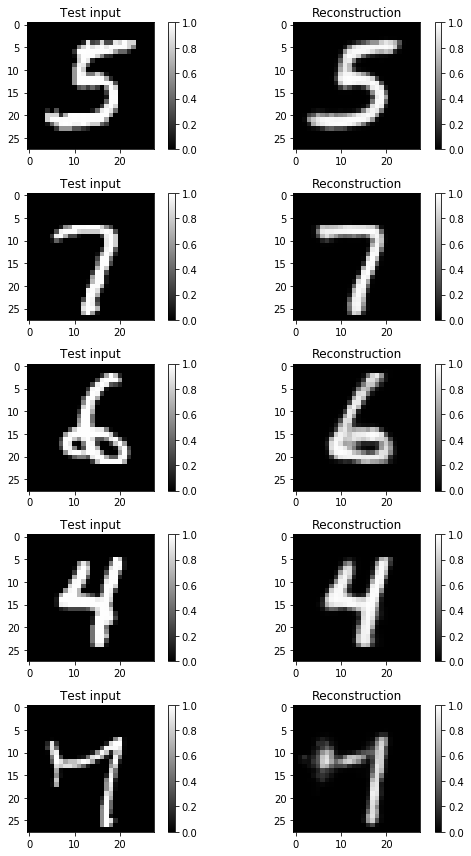

In [9]:
batch = datasets.batches(train_x, train_y, batch_size=batch_size)
x_sample, _ = next(batch)
x_reconstruct = reconstruct(x_sample)
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

# Adversarial Attack

In [10]:
def plot_images(images=[],titles=[],suptitle=''):
    num_colums = 3
    num_imgs = len(images)
    num_rows = 2
    
    plt.figure(figsize=(10,5))
    plt.suptitle(suptitle,fontsize=16)
    for i in range(num_imgs):
        plt.subplot(num_rows, num_colums, i+1)
        plt.imshow(images[i].reshape(28,28),vmin=0,vmax=1,cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

def choose_original_target(x):
    n = len(x)
    i_original = np.random.choice(n)
    i_target = np.random.choice(n)
    original, target = x[i_original], x[i_target]
    return original, target

def stack(array, stack_size=100):
    return np.array([array for i in range(stack_size)])

def get_z(X):
    z = sess.run((z_mean), feed_dict={x: X})
    return z

def reset_attack():
    z = sess.run(init_attack)

def fit_attack(feed_dict):
    target_loss, _ = sess.run((target_cost, target_opt), feed_dict=feed_dict)
    return target_loss

def get_vars(X):
    return sess.run((out_mean, attack, adv_x), feed_dict={x: X})
    
def distance(a, b):
    return np.mean(np.linalg.norm(a-b, axis=1))

def norm(a):
    return np.linalg.norm(a)

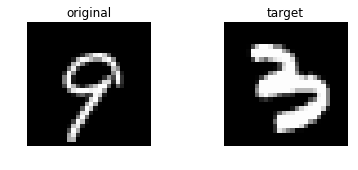

In [34]:
orig, targ = choose_original_target(train_x)
orig = stack(orig, stack_size=100)
targ = stack(targ, stack_size=100)

reset_attack()
target_z = np.array([get_z(targ)[0]])
orig_recon = reconstruct(orig)
targ_recon = reconstruct(targ)

targ_2_orig = distance(orig_recon, targ_recon)
targ_2_recon = distance(targ, targ_recon)
origrec_2_target = distance(orig_recon, targ)


plot_images(images=[orig[0],targ[0]],titles=['original','target'])

1 C: 1024.000000
2.22912
2.22529


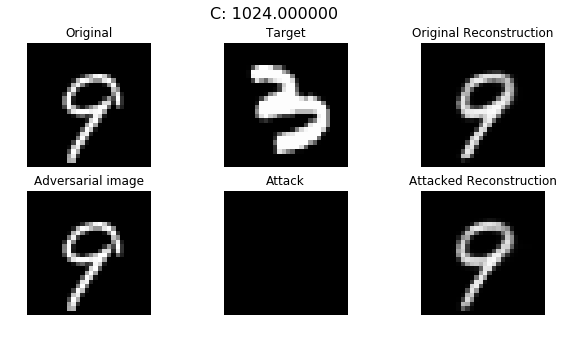

2 C: 830.001221
2.22912
2.22458


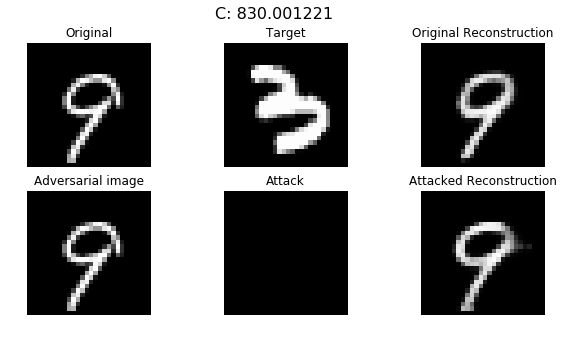

3 C: 672.755920
2.22912
2.2236


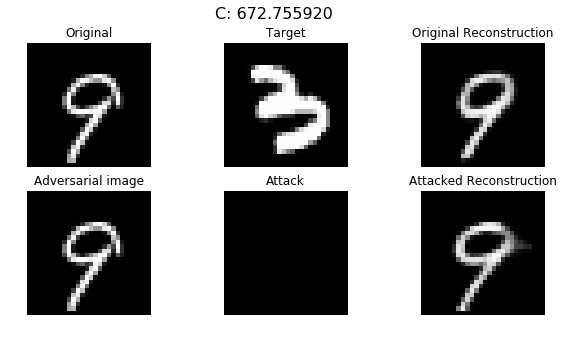

4 C: 545.301025
2.22912
2.22215


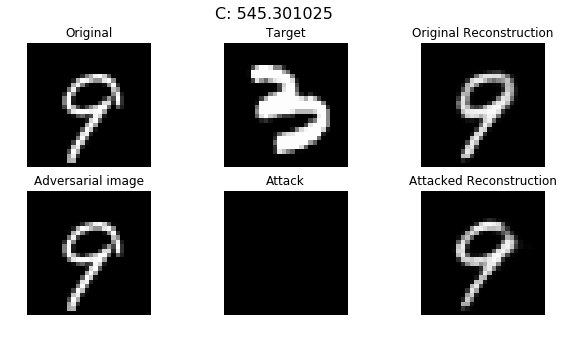

5 C: 441.992706
2.22912
2.22043


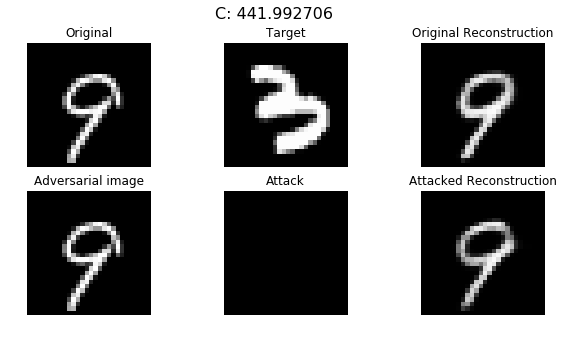

6 C: 358.256348
2.22912
2.21836


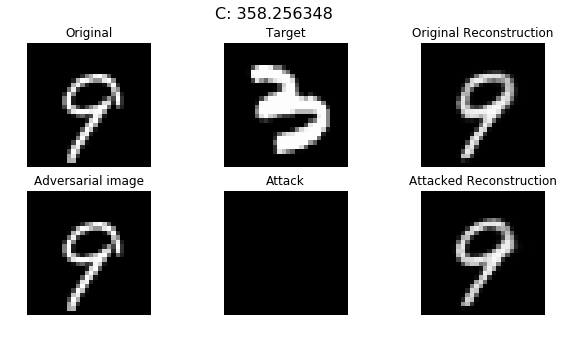

7 C: 290.384003
2.22912
2.2158


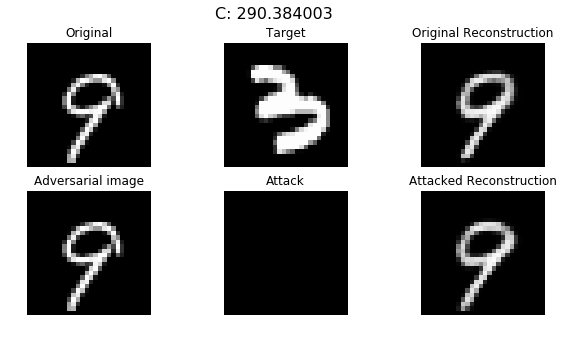

8 C: 235.370209
2.22912
2.21275


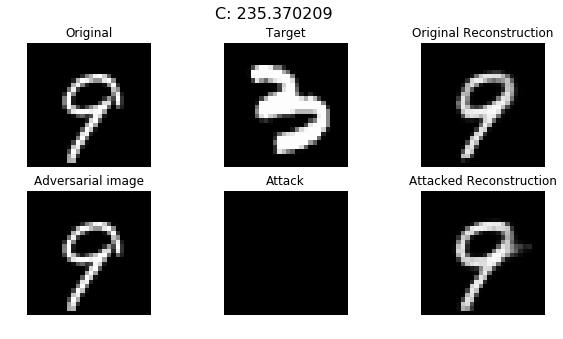

9 C: 190.778870
2.22912
2.20903


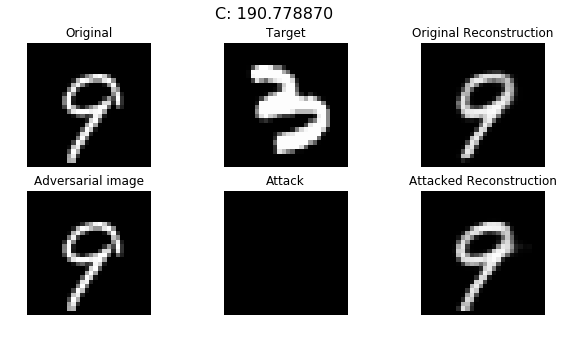

10 C: 154.635452
2.22912
2.20455


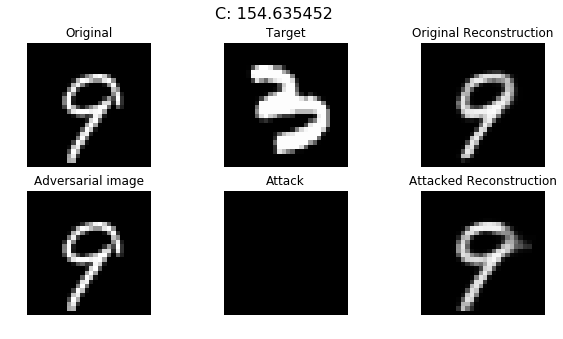

11 C: 125.339470
2.22912
2.1991


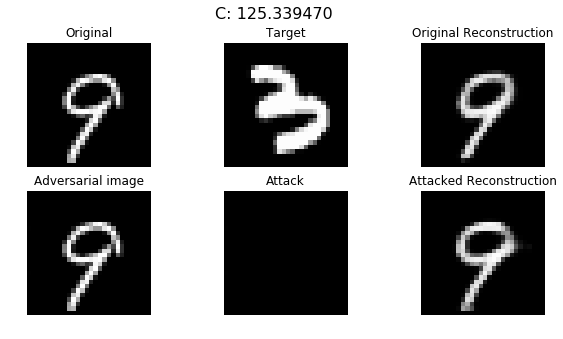

12 C: 101.593666
2.22912
2.19259


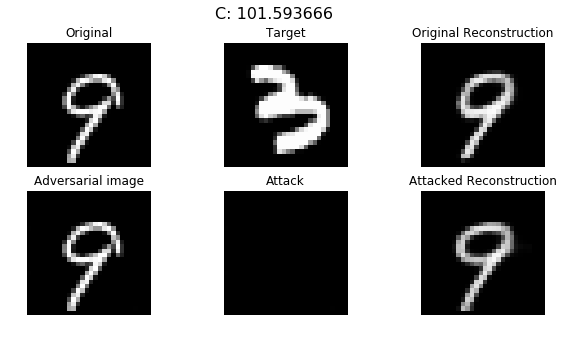

13 C: 82.346550
2.22912
2.18474


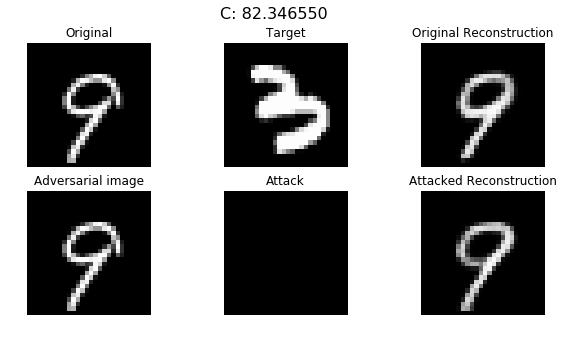

14 C: 66.745842
2.22912
2.17541


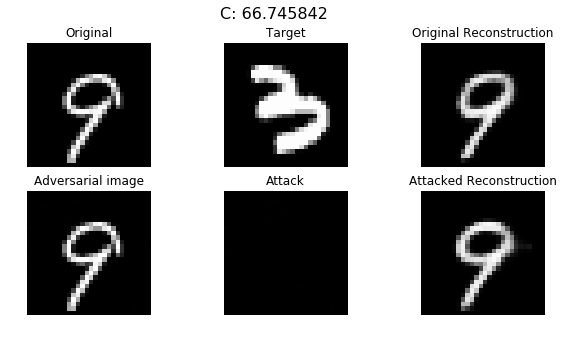

15 C: 54.100716
2.22912
2.16434


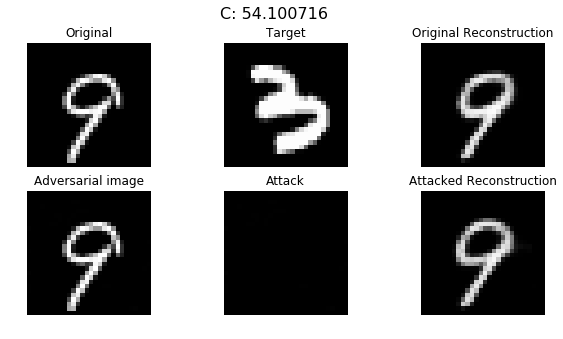

16 C: 43.851231
2.22912
2.15151


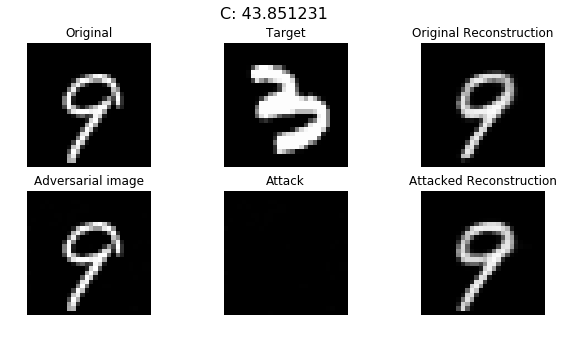

17 C: 35.543533
2.22912
2.13642


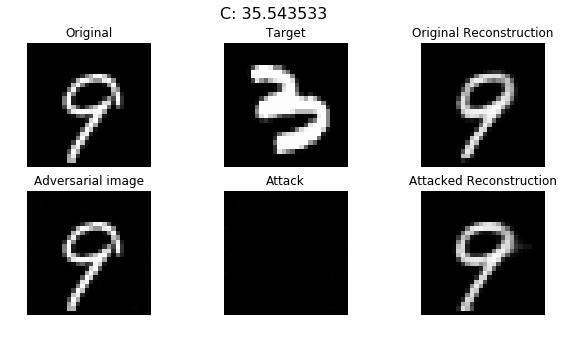

18 C: 28.809742
2.22912
2.11909


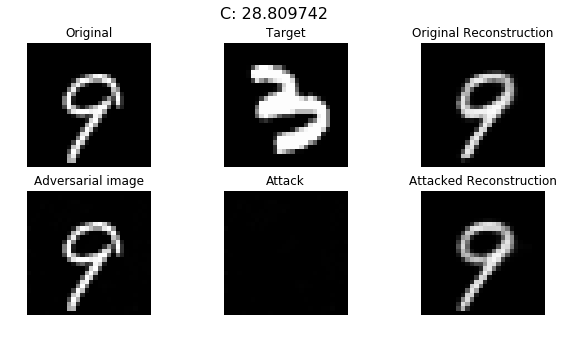

19 C: 23.351681
2.22912
2.09925


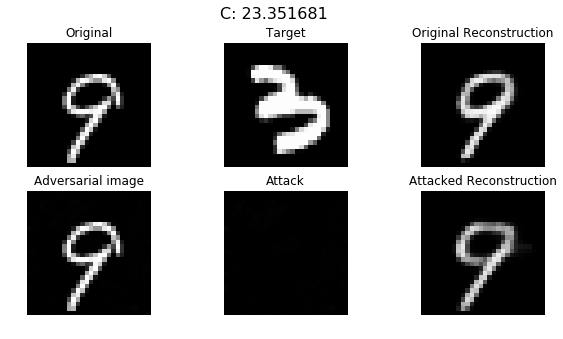

20 C: 18.927662
2.22912
2.07696


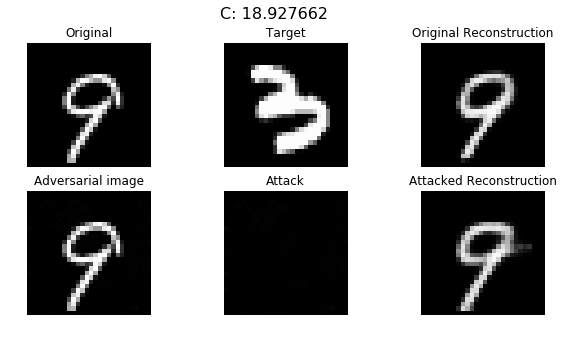

21 C: 15.341780
2.22912
2.05226


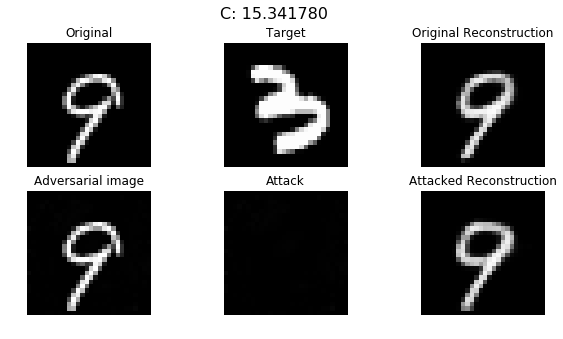

22 C: 12.435250
2.22912
2.02523


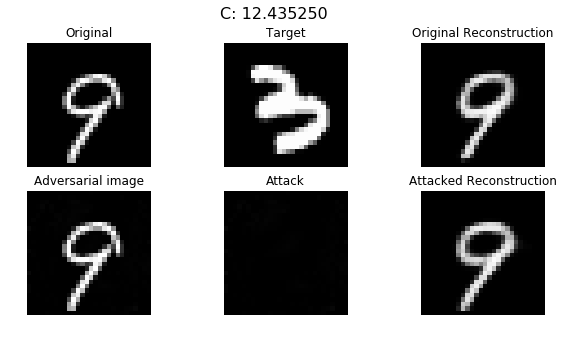

23 C: 10.079369
2.22912
1.99565


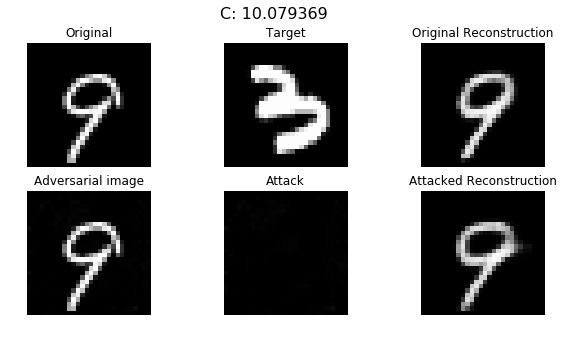

24 C: 8.169813
2.22912
1.96351


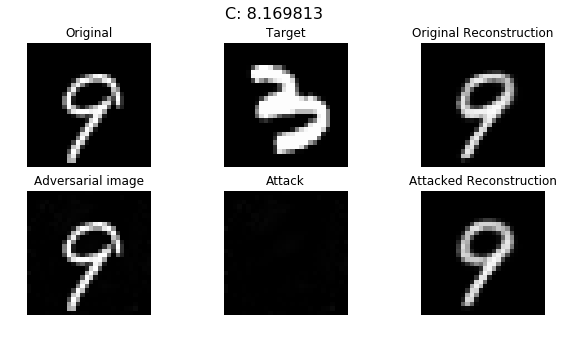

25 C: 6.622026
2.22912
1.92857


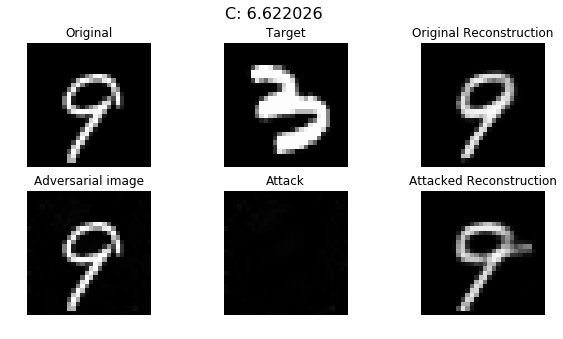

26 C: 5.367471
2.22912
1.89068


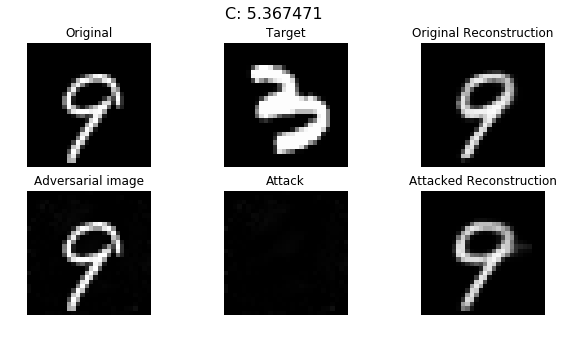

27 C: 4.350593
2.22912
1.85004


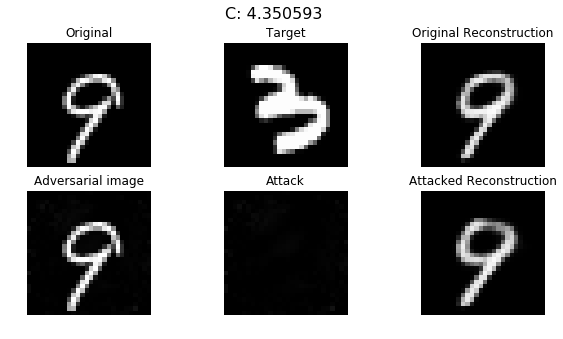

28 C: 3.526365
2.22912
1.80685


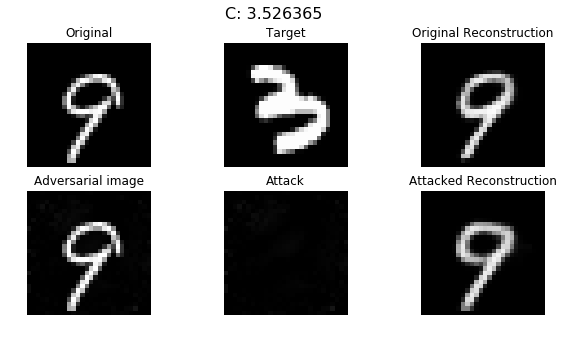

29 C: 2.858289
2.22912
1.76088


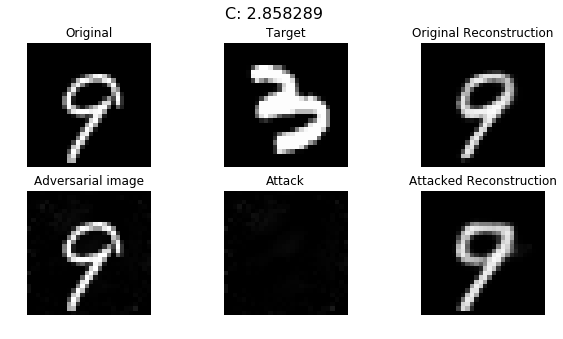

30 C: 2.316780
2.22912
1.71192


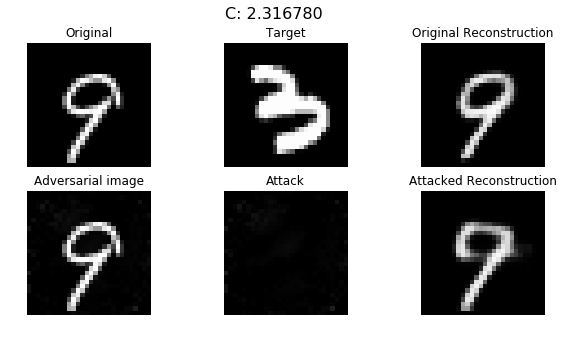

31 C: 1.877862
2.22912
1.6602


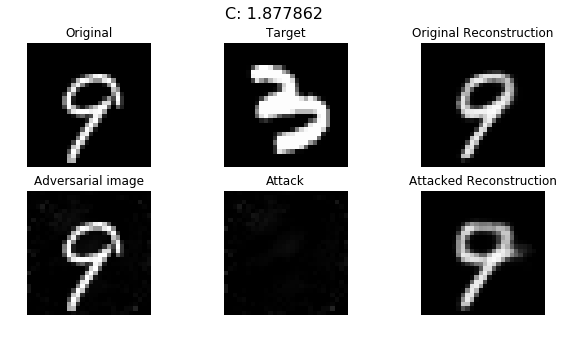

32 C: 1.522097
2.22912
1.60558


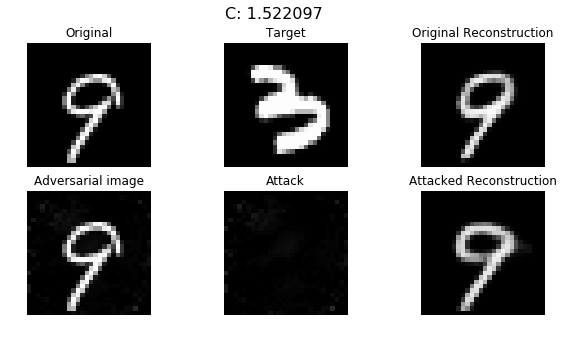

33 C: 1.233733
2.22912
1.54734


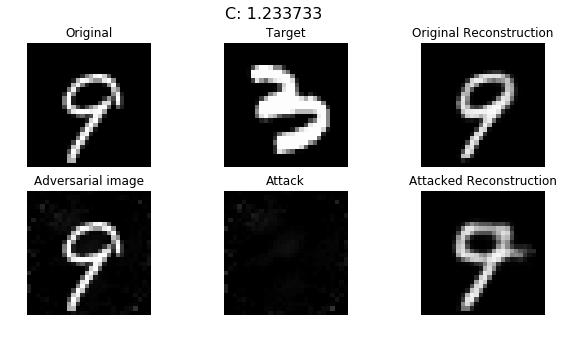

34 C: 1.000000
2.22912
1.48469


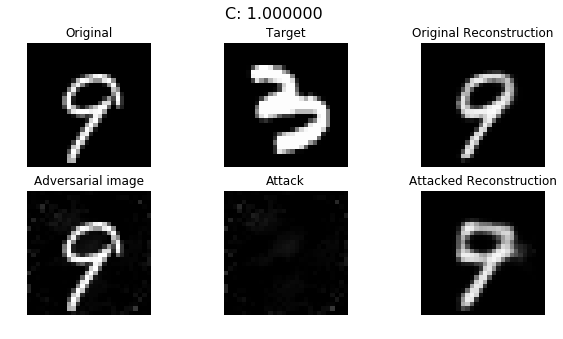

35 C: 0.810548
2.22912
1.4173


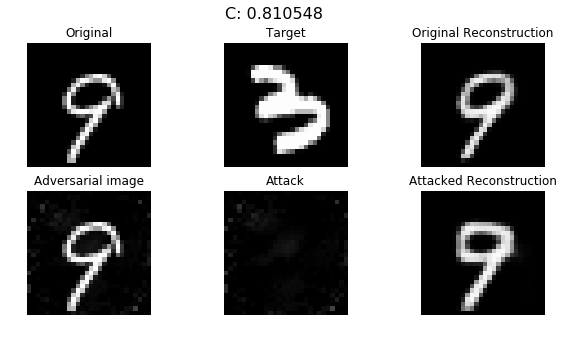

36 C: 0.656988
2.22912
1.34512


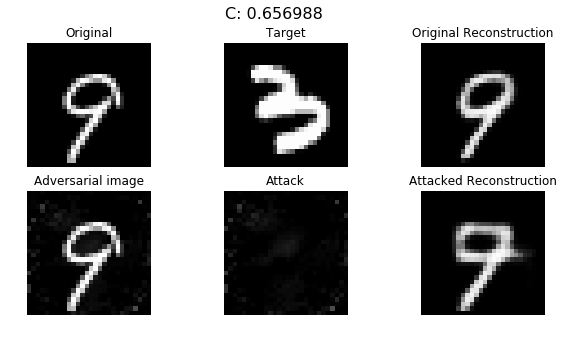

37 C: 0.532521
2.22912
1.26848


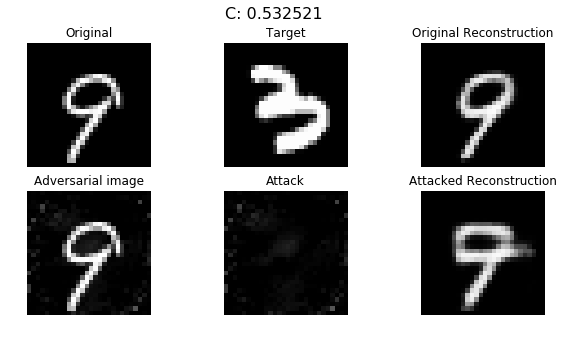

38 C: 0.431634
2.22912
1.18832


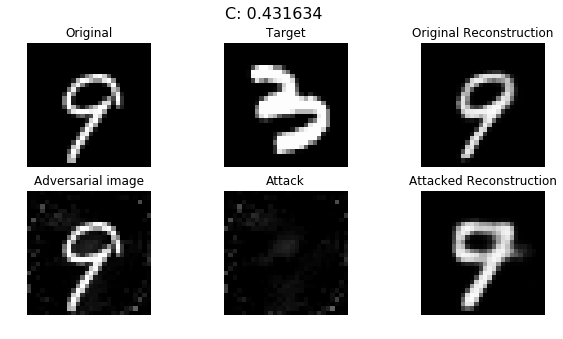

39 C: 0.349860
2.22912
1.10641


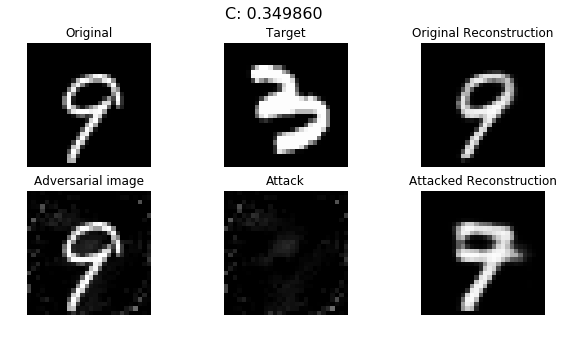

40 C: 0.283578
2.22912
1.02354


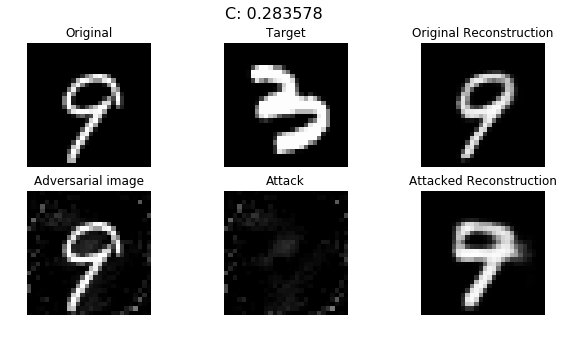

41 C: 0.229854
2.22912
0.936352


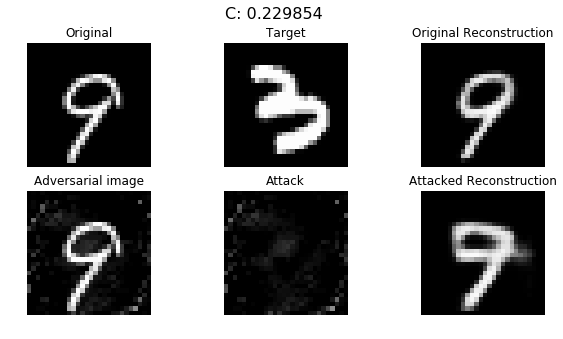

42 C: 0.186307
2.22912
0.849922


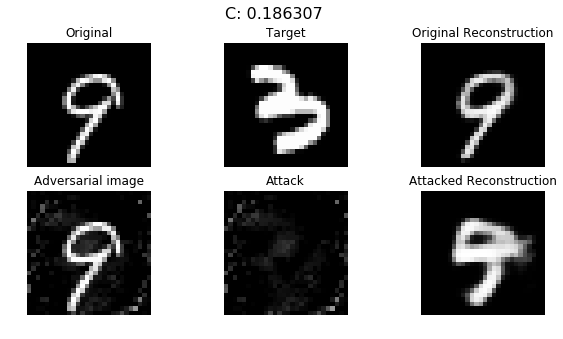

43 C: 0.151011
2.22912
0.77572


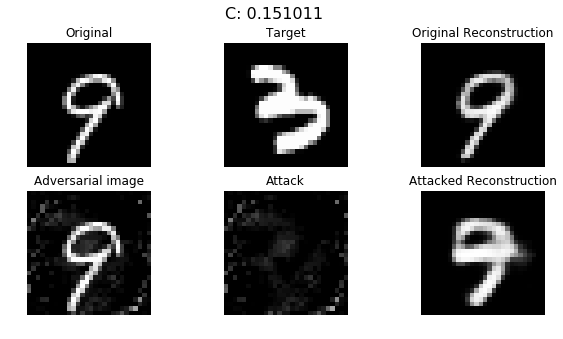

44 C: 0.122402
2.22912
0.712972


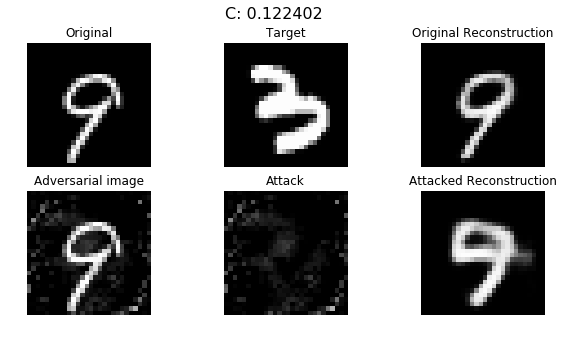

45 C: 0.099213
2.22912
0.615998


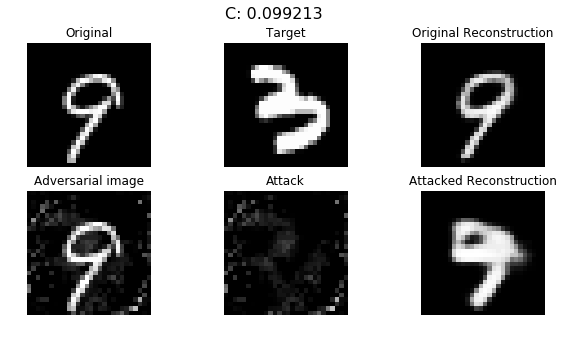

46 C: 0.080417
2.22912
0.56412


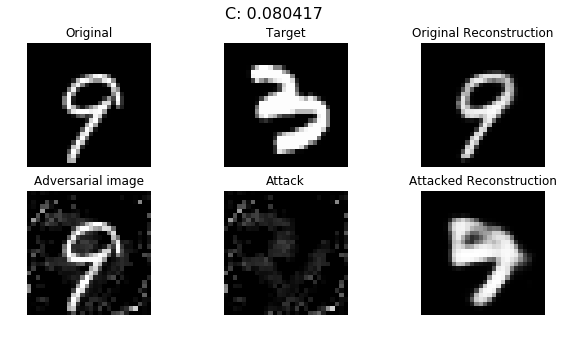

47 C: 0.065181
2.22912
0.502496


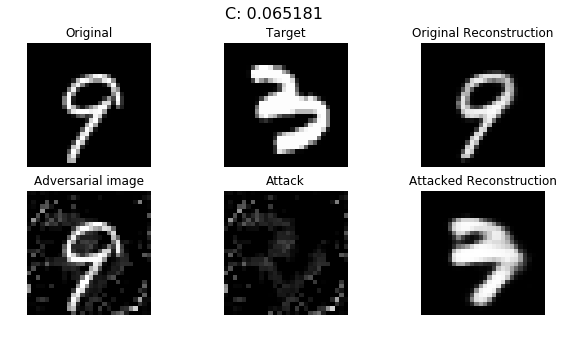

48 C: 0.052833
2.22912
0.444308


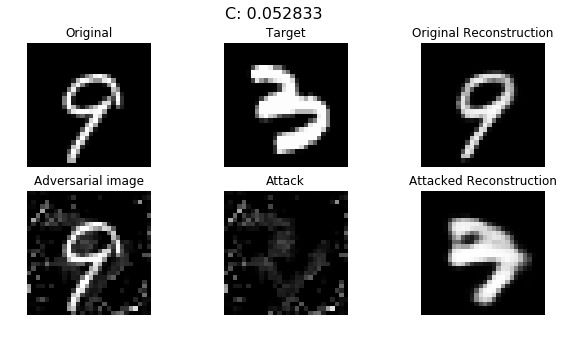

49 C: 0.042823
2.22912
0.397207


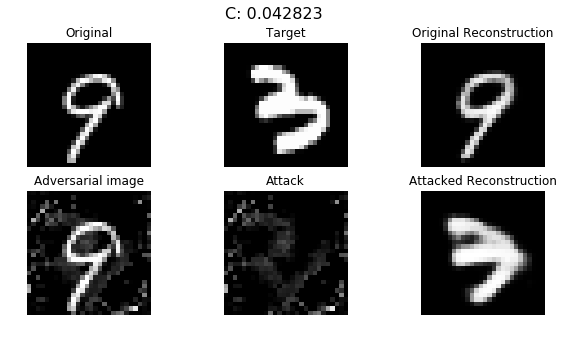

50 C: 0.034710
2.22912
0.346809


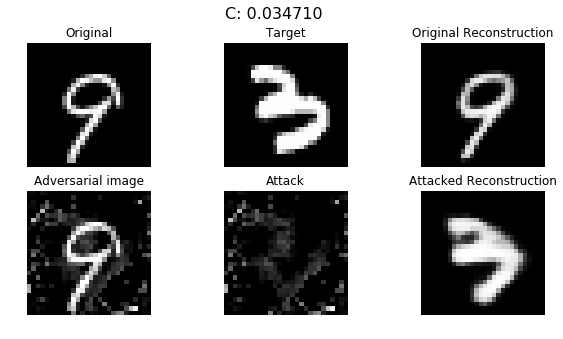

51 C: 0.028135
2.22912
0.29427


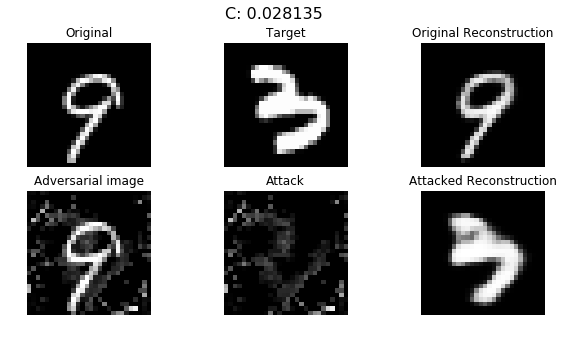

52 C: 0.022804
2.22912
0.263876


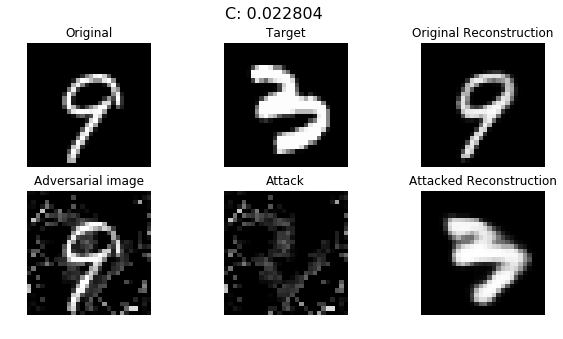

53 C: 0.018484
2.22912
0.229679


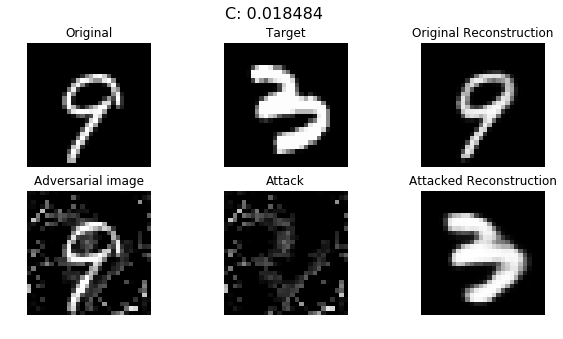

54 C: 0.014982
2.22912
0.200458


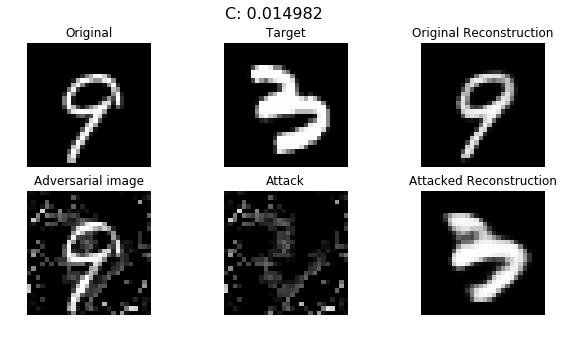

55 C: 0.012144
2.22912
0.176296


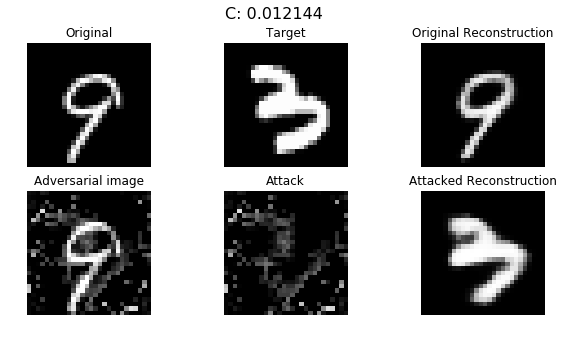

56 C: 0.009843
2.22912
0.143212


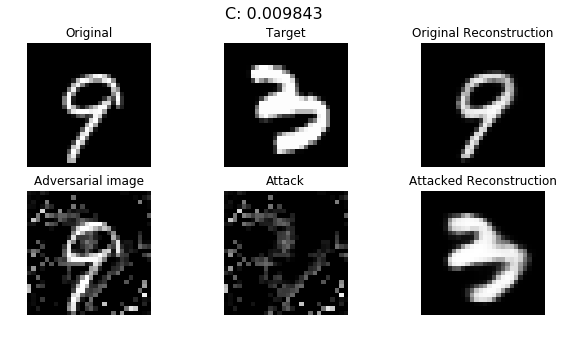

57 C: 0.007978
2.22912
0.12942


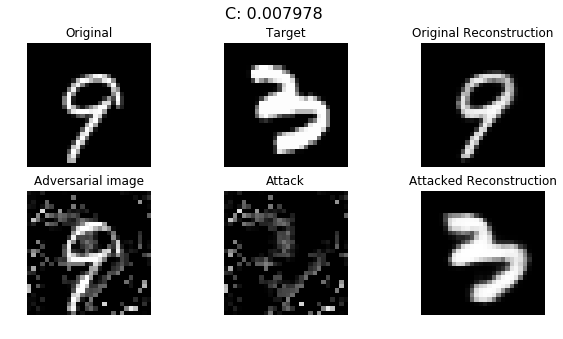

58 C: 0.006467
2.22912
0.110717


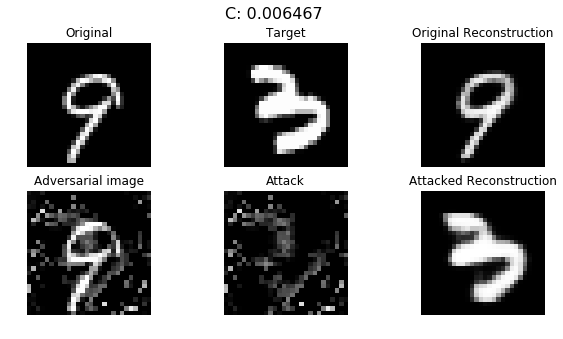

59 C: 0.005242
2.22912
0.0938399


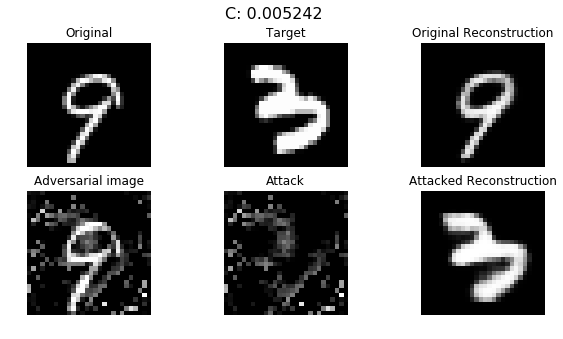

60 C: 0.004249
2.22912
0.081508


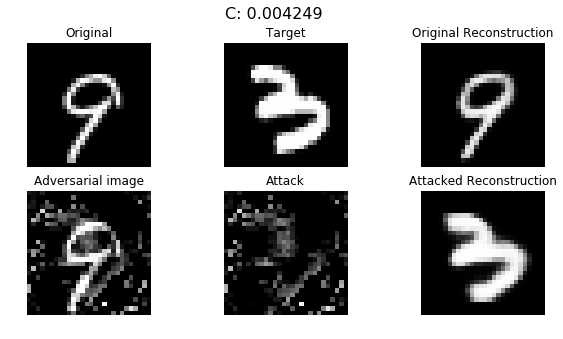

61 C: 0.003444
2.22912
0.0697884


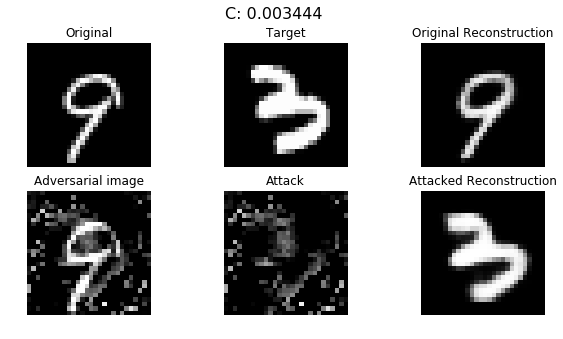

62 C: 0.002791
2.22912
0.0606336


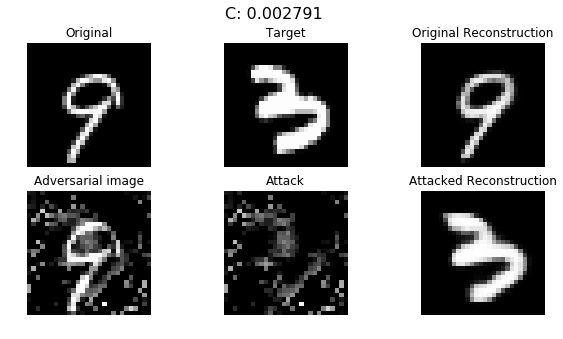

63 C: 0.002262
2.22912
0.0536809


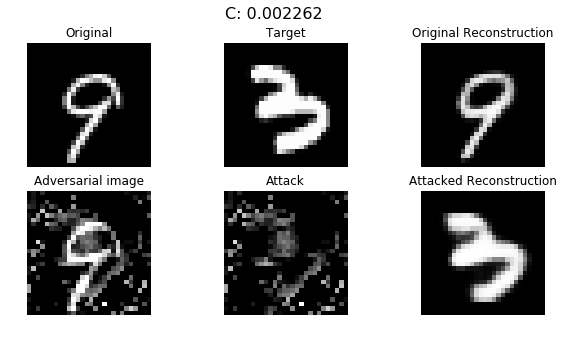

64 C: 0.001834
2.22912
0.0459548


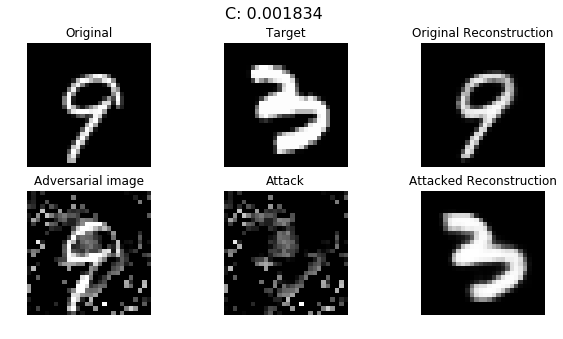

65 C: 0.001486
2.22912
0.0396234


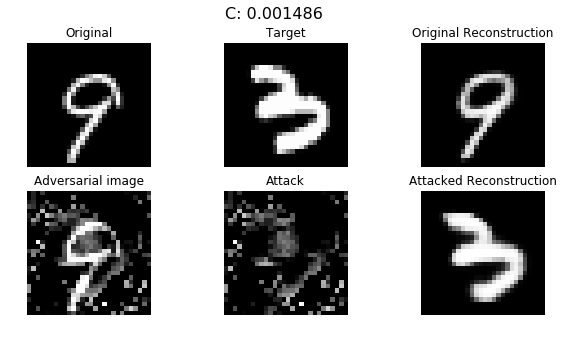

66 C: 0.001205
2.22912
0.0343511


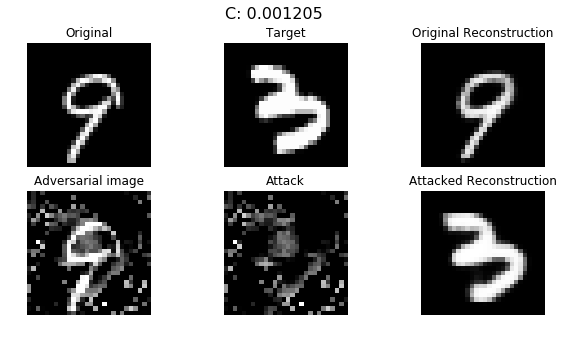

67 C: 0.000977
2.22912
0.0297906


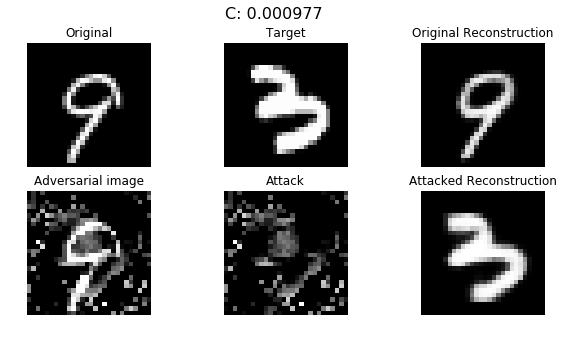

68 C: 0.000792
2.22912
0.0260502


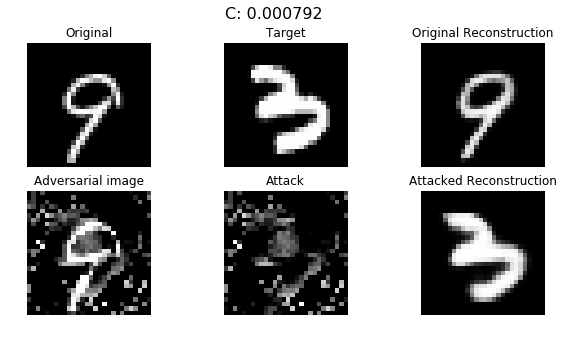

69 C: 0.000642
2.22912
0.022829


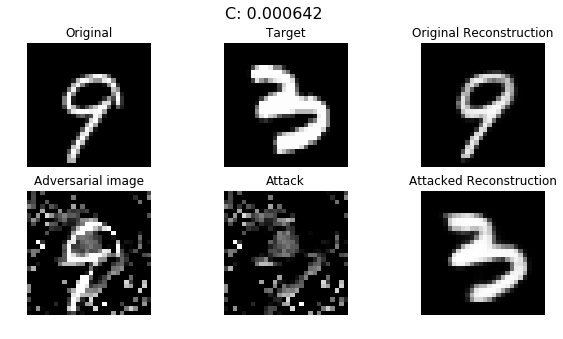

70 C: 0.000520
2.22912
0.0202631


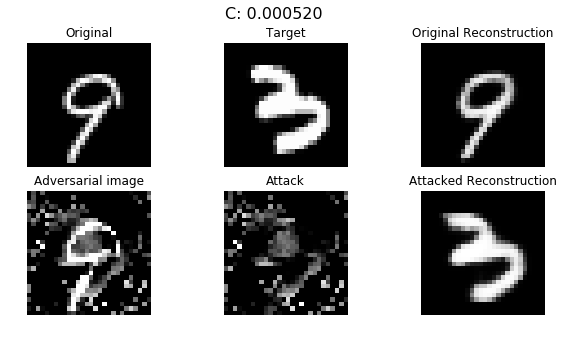

71 C: 0.000422
2.22912
0.0181389


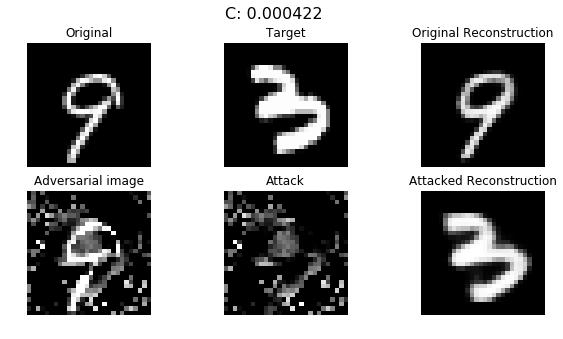

72 C: 0.000342
2.22912
0.0166536


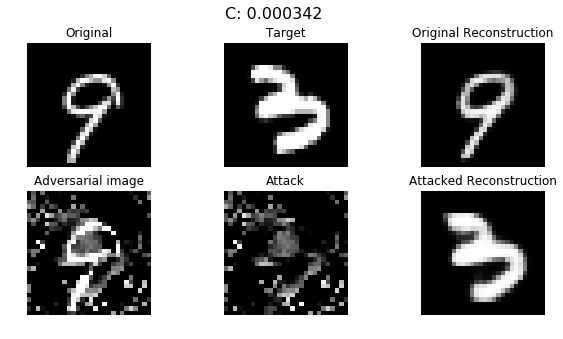

73 C: 0.000277
2.22912
0.0150738


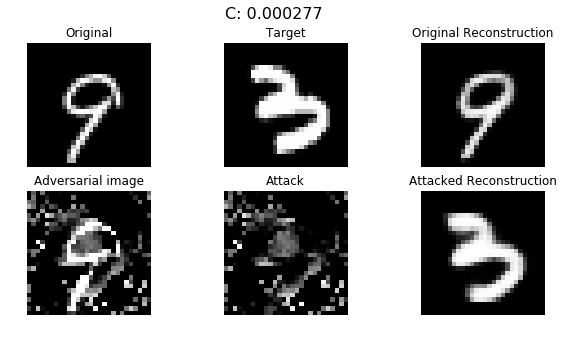

74 C: 0.000224
2.22912
0.0139489


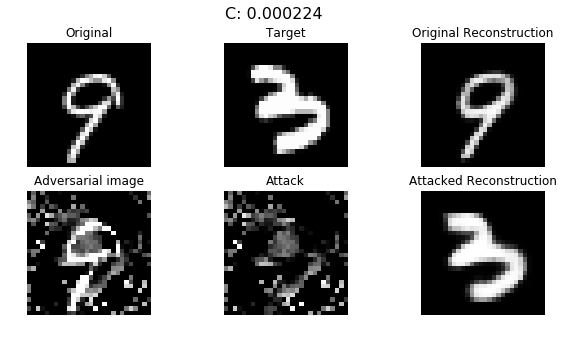

75 C: 0.000182
2.22912
0.0128033


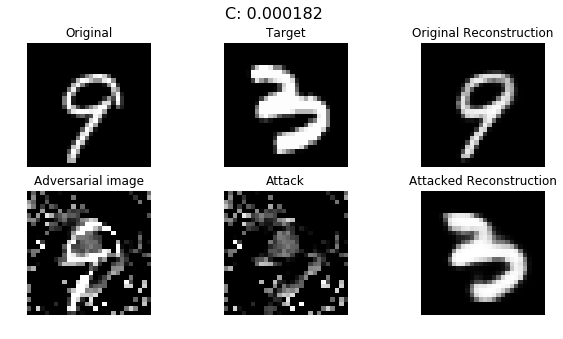

76 C: 0.000147
2.22912
0.0120753


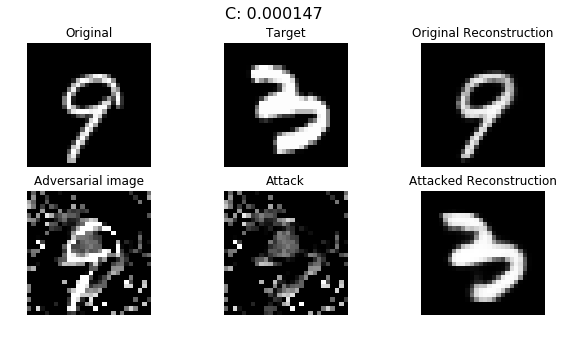

77 C: 0.000120
2.22912
0.0112595


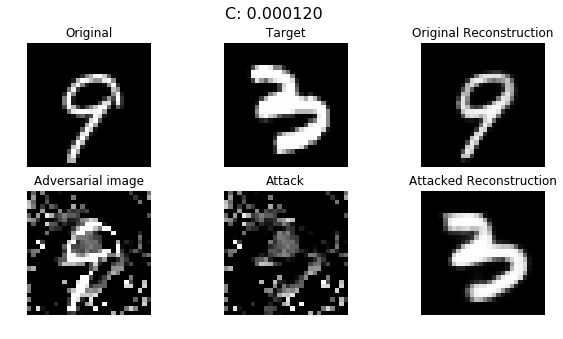

78 C: 0.000097
2.22912
0.0106983


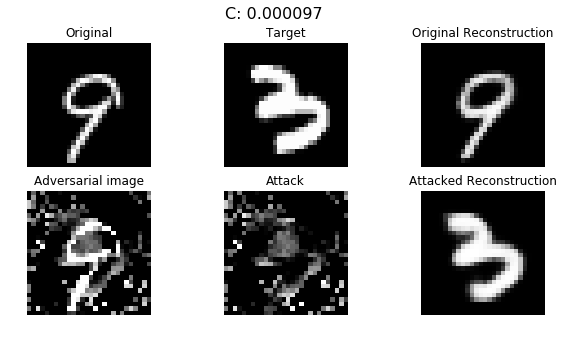

79 C: 0.000079
2.22912
0.0102271


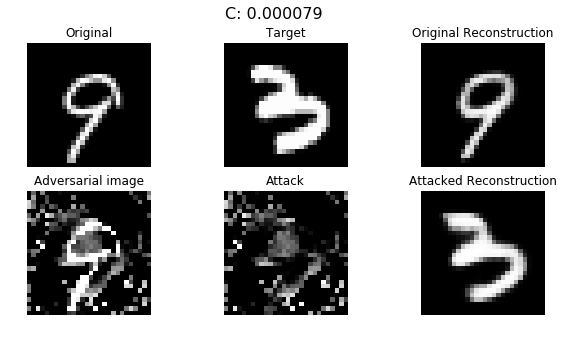

80 C: 0.000064
2.22912
0.00983261


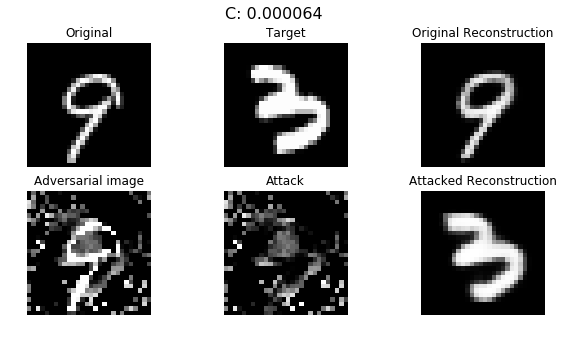

81 C: 0.000052
2.22912
0.00951939


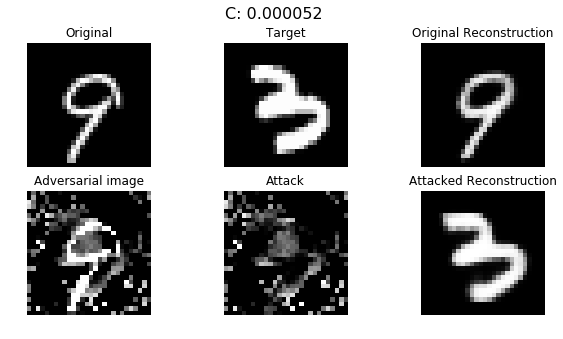

82 C: 0.000042
2.22912
0.0092645


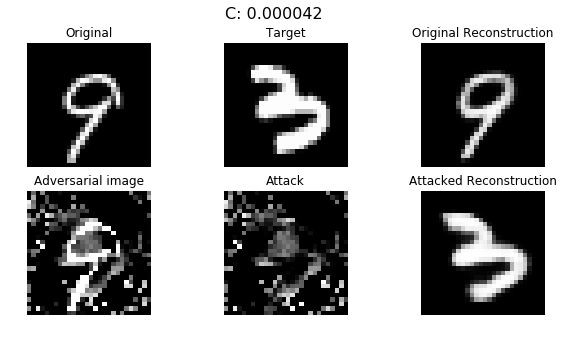

83 C: 0.000034
2.22912
0.00905514


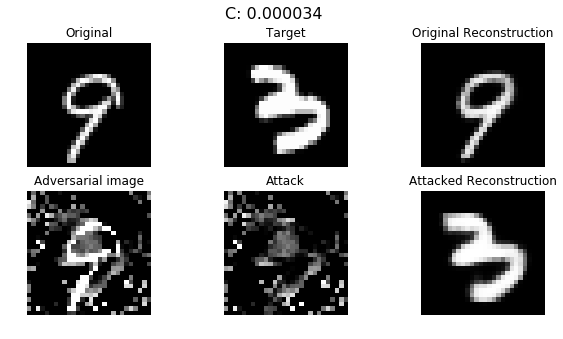

84 C: 0.000027
2.22912
0.00888712


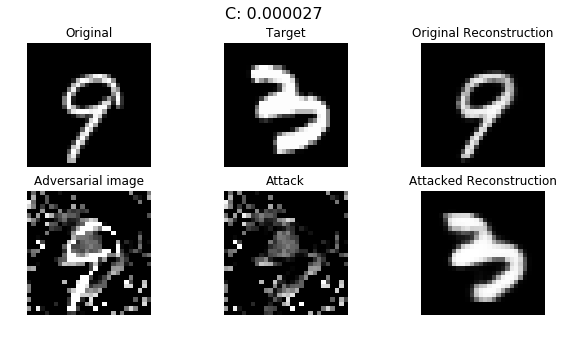

85 C: 0.000022
2.22912
0.00874879


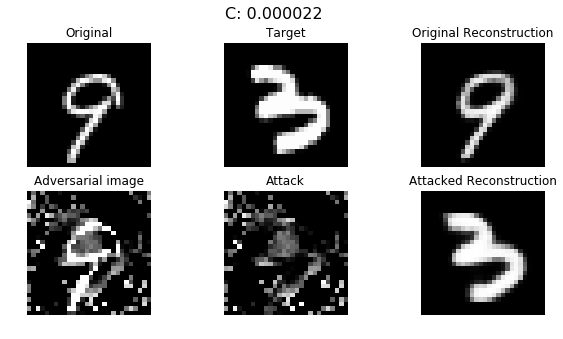

86 C: 0.000018
2.22912
0.00863873


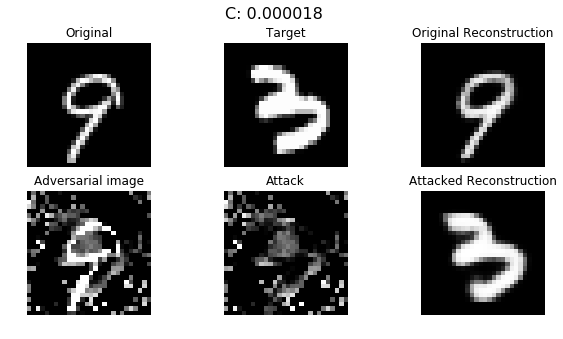

87 C: 0.000015
2.22912
0.00854682


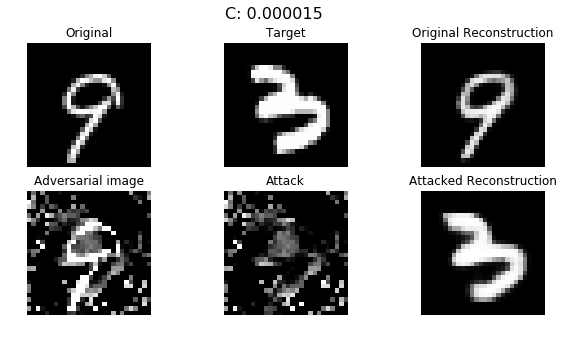

88 C: 0.000012
2.22912
0.00847435


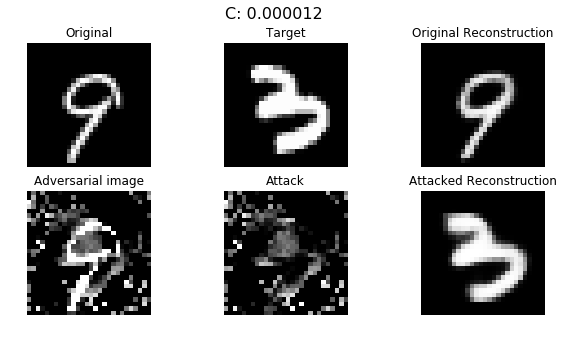

89 C: 0.000010
2.22912
0.00841435


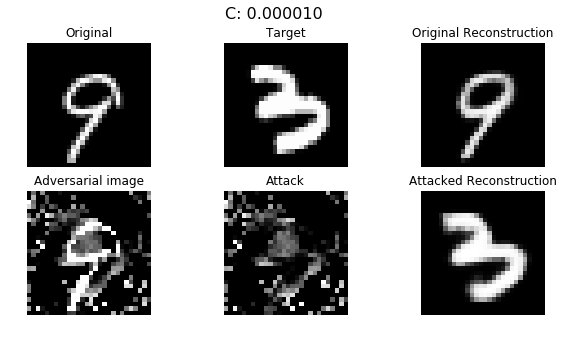

90 C: 0.000008
2.22912
0.00836678


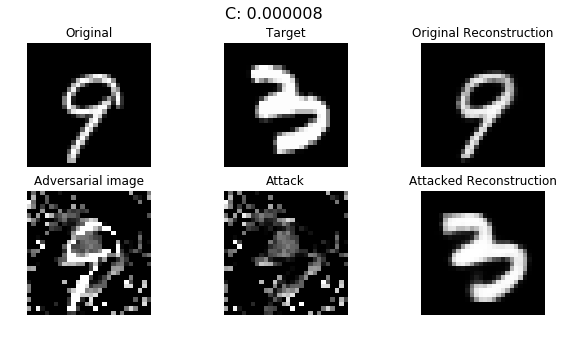

91 C: 0.000006
2.22912
0.00832659


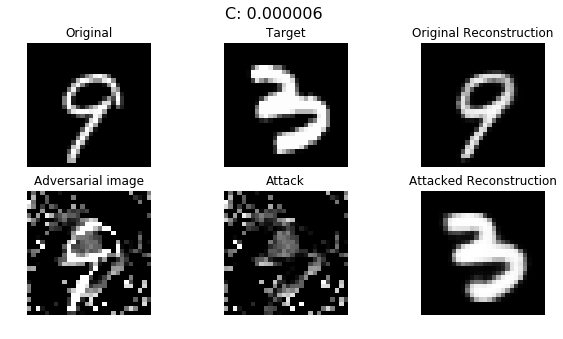

92 C: 0.000005
2.22912
0.00829562


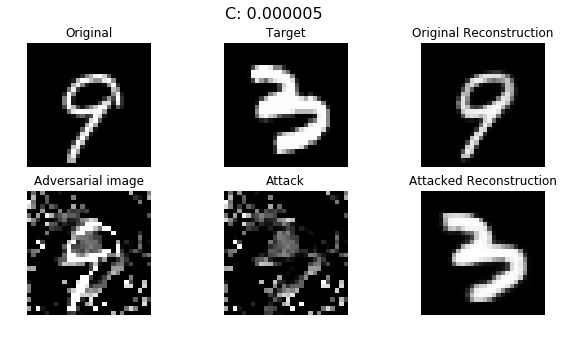

93 C: 0.000004
2.22912
0.00826882


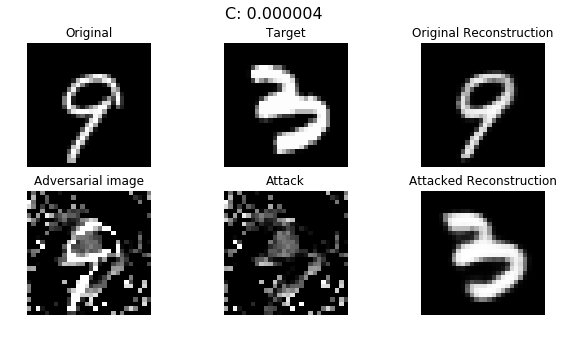

94 C: 0.000003
2.22912
0.00824884


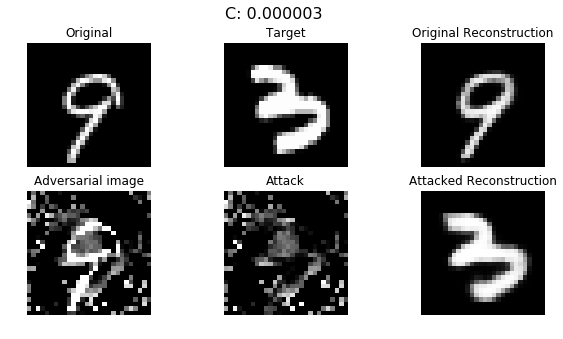

95 C: 0.000003
2.22912
0.00823082


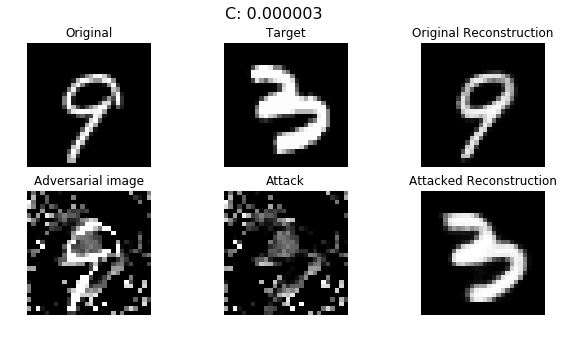

96 C: 0.000002
2.22912
0.00821796


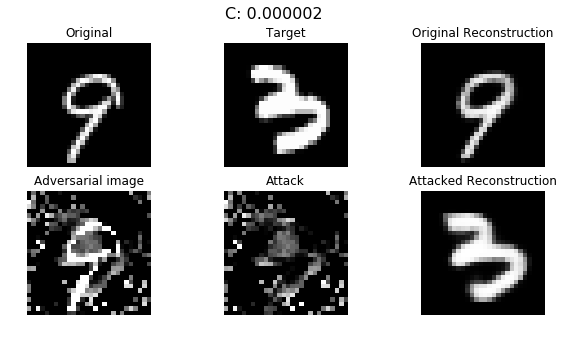

97 C: 0.000002
2.22912
0.0082058


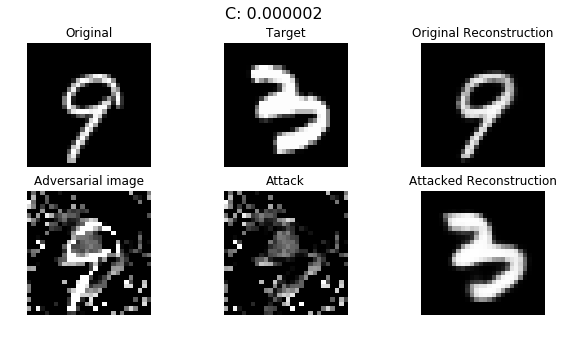

98 C: 0.000001
2.22912
0.00819772


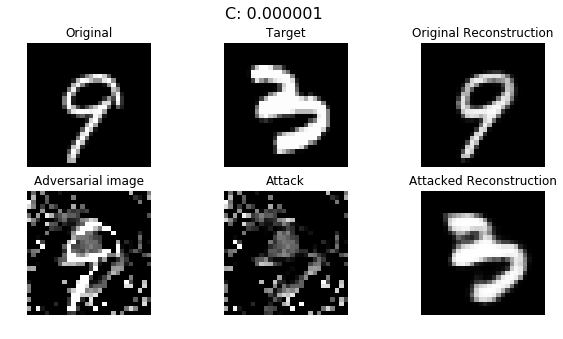

99 C: 0.000001
2.22912
0.00818938


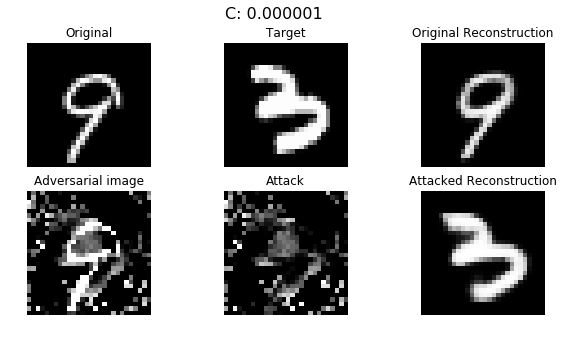

100 C: 0.000001
2.22912
0.0081844


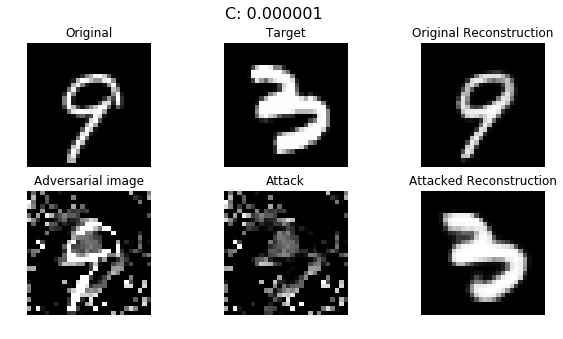

In [39]:
#Vaores de C para explorar
Cs = np.logspace(10, -20, 100, base = 2, dtype = np.float32)

points = []
titles = ['Original','Target','Original Reconstruction',
              'Adversarial image','Attack','Attacked Reconstruction']
for i, c in enumerate(Cs):
    reset_attack()
    feed_dict = {x:orig, Target:target_z, C:c}
    print('%d C: %f'%(i+1, c))
    for i in range(2000):
        loss = fit_attack(feed_dict)
        
        if i % 1000 == 0:
            print(np.mean(loss))
    
    recon, att, ad_img = get_vars(orig)
    
    size_attack = norm(att)
    dist_recon = distance(recon,targ)
    
    point = (size_attack,dist_recon)
    points.append(point)
    images = [orig[0], targ[0], orig_recon[0], ad_img[0], att, recon[0]]
    suptitle='C: %f ' % c
    plot_images(images=images,titles=titles,suptitle=suptitle)
    

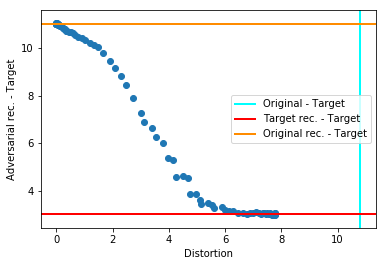

In [40]:
def plot_results(points):
    plt.figure()
    plt.axvline(targ_2_orig, color='cyan', linewidth=2, label="Original - Target")
    plt.axhline(targ_2_recon, color='red', linewidth=2, label="Target rec. - Target")
    plt.axhline(origrec_2_target, color='DarkOrange', linewidth=2, label="Original rec. - Target")
    x,y=list(zip(*points))
    plt.scatter(x,y)
    plt.ylabel("Adversarial rec. - Target")
    plt.xlabel("Distortion")
    plt.legend()
plot_results(points)